## Split the data into train, val and test

In [61]:
from os import mkdir
import glob
import random
import shutil
import os

VAL_SIZE = 0.25
TEST_SIZE = 0.15

flower_classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
imgs_dir = 'flowers'

train_imgs = []
test_imgs = []
val_imgs = []


root_dir = os.getcwd()
val_path = root_dir + '/val'
train_path = root_dir + '/train'
test_path = root_dir + '/test'

'''
for class_ in flower_classes:
    
    per_class_imgs = glob.glob(root_dir + "/" + imgs_dir + "/" + class_ + "/*.jpg")
    val_imgs = random.sample(per_class_imgs, int(VAL_SIZE * len(per_class_imgs)))
    per_class_imgs = [img for img in per_class_imgs if img not in val_imgs]
    
    test_imgs = random.sample(per_class_imgs, int(TEST_SIZE * len(per_class_imgs)))
    train_imgs = [img for img in per_class_imgs if img not in test_imgs]
    
    mkdir(val_path + '/' + class_)
    mkdir(train_path + '/' + class_)
    mkdir(test_path + '/' + class_)

    for img in val_imgs:
        shutil.copy(img, val_path + '/' + class_)
    
    for img in test_imgs:
        shutil.copy(img, test_path + '/' + class_)
    
    for img in train_imgs:
        shutil.copy(img, train_path + '/' + class_)
'''

'\nfor class_ in flower_classes:\n    \n    per_class_imgs = glob.glob(root_dir + "/" + imgs_dir + "/" + class_ + "/*.jpg")\n    val_imgs = random.sample(per_class_imgs, int(VAL_SIZE * len(per_class_imgs)))\n    per_class_imgs = [img for img in per_class_imgs if img not in val_imgs]\n    \n    test_imgs = random.sample(per_class_imgs, int(TEST_SIZE * len(per_class_imgs)))\n    train_imgs = [img for img in per_class_imgs if img not in test_imgs]\n    \n    mkdir(val_path + \'/\' + class_)\n    mkdir(train_path + \'/\' + class_)\n    mkdir(test_path + \'/\' + class_)\n\n    for img in val_imgs:\n        shutil.copy(img, val_path + \'/\' + class_)\n    \n    for img in test_imgs:\n        shutil.copy(img, test_path + \'/\' + class_)\n    \n    for img in train_imgs:\n        shutil.copy(img, train_path + \'/\' + class_)\n'

## Training on inception and visulazing the layers

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dropout, Dense, Input
from keras.models import Sequential
from keras.models import Model
import keras.backend as K
import pickle

## Functional model

In [3]:
img_size = 299
batch_size = 32

#data generator for train and val data
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.2,
                                   height_shift_range=0.2, channel_shift_range=0.0, 
                                   fill_mode='nearest', cval=0.0, horizontal_flip=True,
                                   vertical_flip=True, rescale=1./255, preprocessing_function=None)

val_datagen = ImageDataGenerator(rescale=1./255)



train_gen = train_datagen.flow_from_directory(train_path, target_size = (img_size, img_size), 
                                              batch_size = batch_size, class_mode = 'categorical')
val_gen = val_datagen.flow_from_directory(val_path, target_size = (img_size, img_size), 
                                              batch_size = batch_size, class_mode = 'categorical')


inp = Input((img_size, img_size, 3))


inceptionV3_model = InceptionV3(include_top = False, weights='imagenet', 
                                input_tensor = inp, input_shape = (img_size, img_size, 3), pooling = 'avg')
x = inceptionV3_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
out = Dense(5, activation='softmax')(x)

inceptionV3_model = Model(inp, out)
#inceptionV3_model.summary()

inceptionV3_model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy')
inception_history = inceptionV3_model.fit_generator(train_gen, steps_per_epoch = 100, epochs = 1,
                                      validation_data = val_gen, verbose = 1)


Found 2759 images belonging to 5 classes.
Found 1080 images belonging to 5 classes.
Epoch 1/1
100/100 [==============================] - 88s 876ms/step - loss: 0.7604 - val_loss: 0.3537


In [4]:
inceptionV3_model.save('inception.h5')
with open('incepton_history', 'wb') as file_:
    pickle.dump(inception_history.history, file_)

In [5]:
layers_outputs = [layer.output for layer in inceptionV3_model.layers[:50]]

test_img = test_path + '/daisy/10466290366_cc72e33532.jpg'

img = image.load_img(test_img, target_size = (img_size, img_size, 3))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

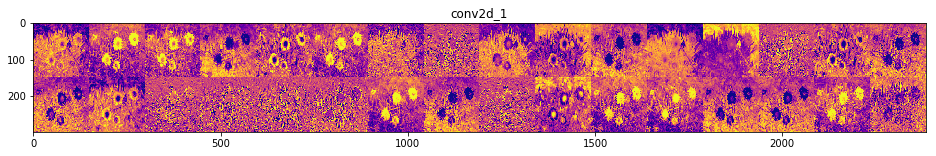

In [6]:
activation_model = Model(inputs = inceptionV3_model.input , outputs = layers_outputs)
activations = activation_model.predict(img_tensor)


layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[1], activations[3], activations[11], activations[13], activations[18], activations[20]]

img_per_col = 16 # the number of columns in the grid

for layer_name, layer_activation in zip(layer_names, activ_list):
    n_features = layer_activation.shape[-1] # How many filters in this layer
    size = layer_activation.shape[1] # what's the size of the image (width with is equal to height in this case)
    n_rows = n_features // img_per_col # the number of rows in the grid
    display_grid = np.zeros((size * n_rows, img_per_col * size))
    
    for row in range(n_rows):
        for col in range(img_per_col):
            channel_image = layer_activation[0, :, :, row * img_per_col + col]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    #plt.savefig(layer_name+"_grid.jpg", bbox_inches='tight')
    break
    
    
    

## Sequential

In [54]:
img_size = 299
batch_size = 32

#data generator for train and val data
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.2,
                                   height_shift_range=0.2, channel_shift_range=0.0, 
                                   fill_mode='nearest', cval=0.0, horizontal_flip=True,
                                   vertical_flip=True, rescale=1./255, preprocessing_function=None)

val_datagen = ImageDataGenerator(rescale=1./255)



train_gen = train_datagen.flow_from_directory(train_path, target_size = (img_size, img_size), 
                                              batch_size = batch_size, class_mode = 'categorical')
val_gen = val_datagen.flow_from_directory(val_path, target_size = (img_size, img_size), 
                                              batch_size = batch_size, class_mode = 'categorical')

inceptionV3_model2 = Sequential()
inp = Input((img_size, img_size, 3))



inceptionV3_model2.add(InceptionV3(include_top = False, weights='imagenet',input_tensor = inp, input_shape = (img_size, img_size, 3), pooling = 'avg'))
inceptionV3_model2.add(Dense(256, activation='relu'))
inceptionV3_model2.add(Dropout(0.1))
inceptionV3_model2.add(Dense(5, activation='softmax'))



inceptionV3_model2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy')
inception_history = inceptionV3_model2.fit_generator(train_gen, steps_per_epoch = 100, epochs = 1,
                                      validation_data = val_gen, verbose = 1)

inceptionV3_model2.save('inception2.h5')
with open('incepton_history2', 'wb') as file_:
    pickle.dump(inception_history.history, file_)
    

    

Found 2759 images belonging to 5 classes.
Found 1080 images belonging to 5 classes.
Epoch 1/1
100/100 [==============================] - 93s 933ms/step - loss: 0.7607 - val_loss: 0.3926


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


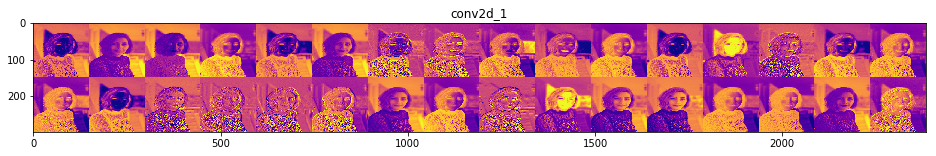

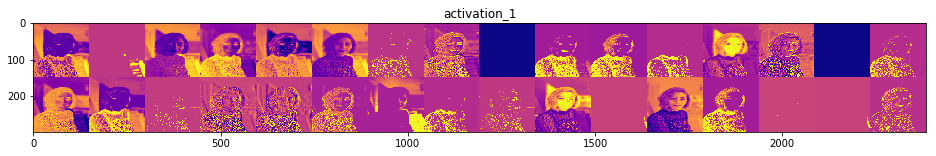

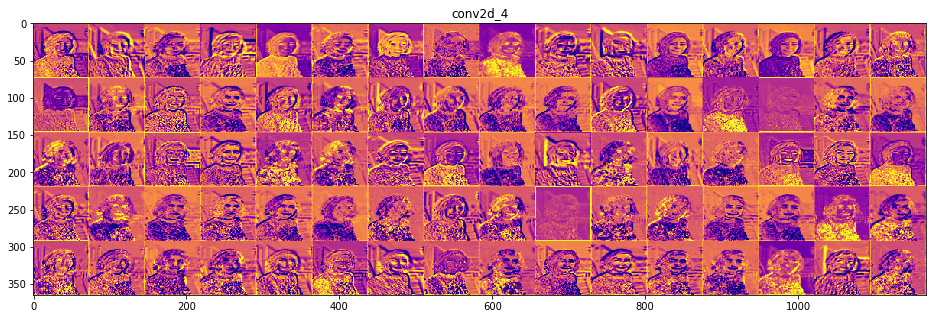

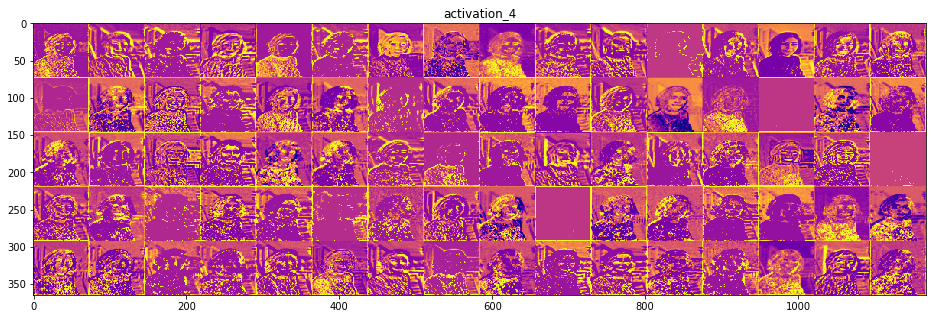

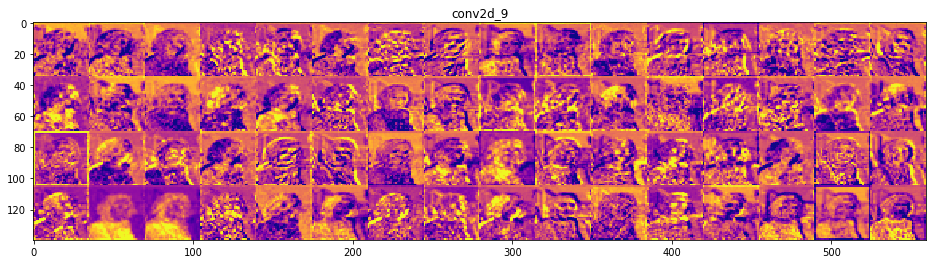

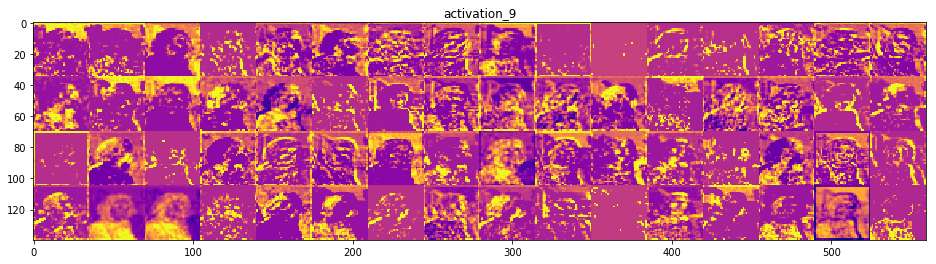

In [65]:
layers_outputs2 = []

for layer in inceptionV3_model2.layers:
    if "layer" not in str(type(layer)): # this is to access the layers inside the inception model
        for l in layer.layers:
            l.outbound_nodes = [] 
            #since this model was a sequential model, the connections have to be force broken. Otherwise
            #it think that it is connected to its next layer
            layers_outputs2.append(l.output)
    else:
        l.outbound_nodes = []
        layers_outputs2.append(l.output)
        
        
test_img = test_path + '/daisy/sara.jpg'

img = image.load_img(test_img, target_size = (img_size, img_size, 3))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.


activation_model = Model(inputs = inp , outputs = layers_outputs2)

    
    
activations = activation_model.predict(img_tensor)


layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[1], activations[3], activations[11], activations[13], activations[18], activations[20]]

img_per_col = 16 # the number of columns in the grid

for layer_name, layer_activation in zip(layer_names, activ_list):
    n_features = layer_activation.shape[-1] # How many filters in this layer
    size = layer_activation.shape[1] # what's the size of the image (width with is equal to height in this case)
    n_rows = n_features // img_per_col # the number of rows in the grid
    display_grid = np.zeros((size * n_rows, img_per_col * size))
    
    for row in range(n_rows):
        for col in range(img_per_col):
            channel_image = layer_activation[0, :, :, row * img_per_col + col]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    #plt.savefig(layer_name+"_grid.jpg", bbox_inches='tight')
    
